<a href="https://colab.research.google.com/github/harnettd/learn-PyTorch/blob/main/02-Neural-Network-Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Neural Network Classification

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Generate Data

In [4]:
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)
df = pd.DataFrame(
    np.hstack((X, y.reshape(-1, 1))),
    columns=['X1', 'X2', 'y']
)
df.head()

,X1,X2,y
0,0.754246,0.231481,1.0
1,-0.756159,0.153259,1.0
2,-0.815392,0.173282,1.0
3,-0.393731,0.692883,1.0
4,0.442208,-0.896723,0.0


### EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      1000 non-null   float64
 1   X2      1000 non-null   float64
 2   y       1000 non-null   float64
dtypes: float64(3)
memory usage: 23.6 KB


In [6]:
df.describe()

,X1,X2,y
count,1000.000000,1000.000000,1000.00000
mean,-0.000448,-0.000804,0.50000
std,0.639837,0.641156,0.50025
min,-1.059502,-1.067768,0.00000
25%,-0.619251,-0.612176,0.00000
50%,0.008762,-0.003949,0.50000
75%,0.621933,0.624822,1.00000
max,1.033712,1.036004,1.00000


In [7]:
df['y'].value_counts()

,count
y,
1.0,500
0.0,500


<Axes: xlabel='X1', ylabel='X2'>

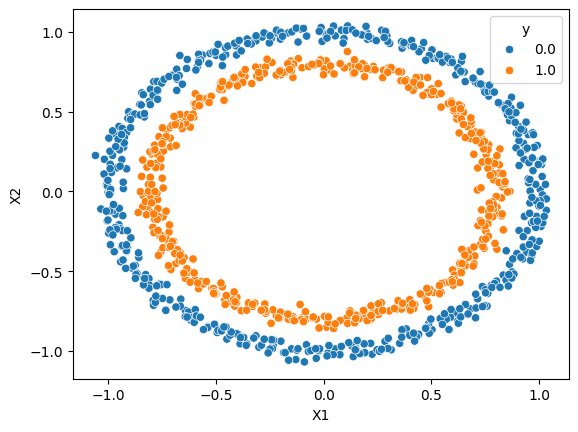

In [8]:
sns.scatterplot(data=df, x='X1', y='X2', hue='y')

## Train-Test Split

In [9]:
X.shape, y.shape

((1000, 2), (1000,))

In [10]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [11]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

# Build Model

In [12]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, X):
        return self.layer_2(self.layer_1(X))

In [13]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
y_logits = model_0(X_test.to(device))
print(f'Model output shape: {y_logits.shape}')
print(f'y_test shape: {y_test.shape}')
y_preds_probs = torch.sigmoid(y_logits)
y_preds_labels = torch.round(y_preds_probs)
y_preds = y_preds_labels.squeeze()
y_preds[:10]

Model output shape: torch.Size([200, 1])
y_test shape: torch.Size([200])


tensor([1., 1., 1., 1., 0., 0., 1., 1., 1., 1.], grad_fn=<SliceBackward0>)

## Train Model

In [15]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [16]:
def accuracy_fn(y_true, y_pred):
    n_preds = len(y_true)
    n_correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = n_correct / n_preds
    return accuracy

In [17]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_0.train()

    y_train_logits = model_0(X_train).squeeze()
    y_train_labels = torch.round(torch.sigmoid(y_train_logits))

    loss = loss_fn(y_train_logits, y_train)
    accuracy = accuracy_fn(y_train, y_train_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        y_test_logits = model_0(X_test).squeeze()
        y_test_labels = torch.round(torch.sigmoid(y_test_logits))
        test_loss = loss_fn(y_test_logits, y_test)
        test_accuracy = accuracy_fn(y_test, y_test_labels)

    ### Printouts
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {accuracy:.3f} | Test Loss: {test_loss:.5f} | Test Accuracy: {test_accuracy:.3f}')


Epoch: 0 | Loss: 0.70226 | Accuracy: 0.530 | Test Loss: 0.71084 | Test Accuracy: 0.500
Epoch: 10 | Loss: 0.69917 | Accuracy: 0.522 | Test Loss: 0.70686 | Test Accuracy: 0.500
Epoch: 20 | Loss: 0.69752 | Accuracy: 0.516 | Test Loss: 0.70442 | Test Accuracy: 0.495
Epoch: 30 | Loss: 0.69649 | Accuracy: 0.514 | Test Loss: 0.70271 | Test Accuracy: 0.495
Epoch: 40 | Loss: 0.69577 | Accuracy: 0.511 | Test Loss: 0.70141 | Test Accuracy: 0.480
Epoch: 50 | Loss: 0.69522 | Accuracy: 0.510 | Test Loss: 0.70037 | Test Accuracy: 0.480
Epoch: 60 | Loss: 0.69481 | Accuracy: 0.509 | Test Loss: 0.69953 | Test Accuracy: 0.480
Epoch: 70 | Loss: 0.69447 | Accuracy: 0.509 | Test Loss: 0.69883 | Test Accuracy: 0.485
Epoch: 80 | Loss: 0.69421 | Accuracy: 0.510 | Test Loss: 0.69825 | Test Accuracy: 0.480
Epoch: 90 | Loss: 0.69400 | Accuracy: 0.511 | Test Loss: 0.69777 | Test Accuracy: 0.480


<Axes: xlabel='X1', ylabel='X2'>

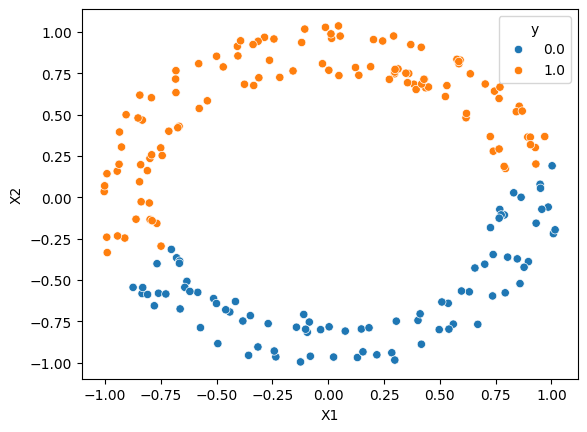

In [18]:
df_pred = pd.DataFrame(
    np.hstack((X_test.numpy(), y_test_labels.numpy().reshape(-1, 1))),
    columns=['X1', 'X2', 'y']
)
sns.scatterplot(data=df_pred, x='X1', y='X2', hue='y')

## A Deeper and Wider Model

In [19]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, X):
        return self.layer_3(self.layer_2(self.layer_1(X)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [20]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [21]:
torch.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
    ### Training
    model_1.train()

    y_train_logits = model_1(X_train).squeeze()
    y_train_labels = torch.round(torch.sigmoid(y_train_logits))

    loss = loss_fn(y_train_logits, y_train)
    accuracy = accuracy_fn(y_train, y_train_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        y_test_logits = model_1(X_test).squeeze()
        y_test_labels = torch.round(torch.sigmoid(y_test_logits))
        test_loss = loss_fn(y_test_logits, y_test)
        test_accuracy = accuracy_fn(y_test, y_test_labels)

    ### Printouts
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {accuracy:.3f} | Test Loss: {test_loss:.5f} | Test Accuracy: {test_accuracy:.3f}')


Epoch: 0 | Loss: 0.69396 | Accuracy: 0.509 | Test Loss: 0.69261 | Test Accuracy: 0.510
Epoch: 100 | Loss: 0.69305 | Accuracy: 0.504 | Test Loss: 0.69379 | Test Accuracy: 0.480
Epoch: 200 | Loss: 0.69299 | Accuracy: 0.511 | Test Loss: 0.69437 | Test Accuracy: 0.460
Epoch: 300 | Loss: 0.69298 | Accuracy: 0.516 | Test Loss: 0.69458 | Test Accuracy: 0.450
Epoch: 400 | Loss: 0.69298 | Accuracy: 0.511 | Test Loss: 0.69465 | Test Accuracy: 0.460
Epoch: 500 | Loss: 0.69298 | Accuracy: 0.510 | Test Loss: 0.69467 | Test Accuracy: 0.460
Epoch: 600 | Loss: 0.69298 | Accuracy: 0.510 | Test Loss: 0.69468 | Test Accuracy: 0.460
Epoch: 700 | Loss: 0.69298 | Accuracy: 0.510 | Test Loss: 0.69468 | Test Accuracy: 0.460
Epoch: 800 | Loss: 0.69298 | Accuracy: 0.510 | Test Loss: 0.69468 | Test Accuracy: 0.460
Epoch: 900 | Loss: 0.69298 | Accuracy: 0.510 | Test Loss: 0.69468 | Test Accuracy: 0.460


<Axes: xlabel='X1', ylabel='X2'>

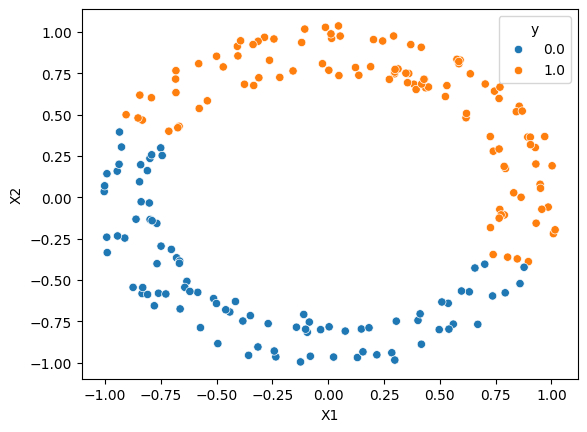

In [22]:
df_pred = pd.DataFrame(
    np.hstack((X_test.numpy(), y_test_labels.numpy().reshape(-1, 1))),
    columns=['X1', 'X2', 'y']
)
sns.scatterplot(data=df_pred, x='X1', y='X2', hue='y')

## A Nonlinear Model

In [23]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, X):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(X)))))

model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [24]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [25]:
epochs = 1000

for epoch in range(epochs):
    ### Training
    model_2.train()

    y_train_logits = model_2(X_train).squeeze()
    y_train_labels = torch.round(torch.sigmoid(y_train_logits))

    loss = loss_fn(y_train_logits, y_train)
    accuracy = accuracy_fn(y_train, y_train_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
        y_test_logits = model_2(X_test).squeeze()
        y_test_labels = torch.round(torch.sigmoid(y_test_logits))
        test_loss = loss_fn(y_test_logits, y_test)
        test_accuracy = accuracy_fn(y_test, y_test_labels)

    ### Printouts
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {accuracy:.3f} | Test Loss: {test_loss:.5f} | Test Accuracy: {test_accuracy:.3f}')


Epoch: 0 | Loss: 0.69295 | Accuracy: 0.500 | Test Loss: 0.69319 | Test Accuracy: 0.500
Epoch: 100 | Loss: 0.69115 | Accuracy: 0.529 | Test Loss: 0.69102 | Test Accuracy: 0.525
Epoch: 200 | Loss: 0.68977 | Accuracy: 0.534 | Test Loss: 0.68940 | Test Accuracy: 0.550
Epoch: 300 | Loss: 0.68795 | Accuracy: 0.530 | Test Loss: 0.68723 | Test Accuracy: 0.560
Epoch: 400 | Loss: 0.68517 | Accuracy: 0.527 | Test Loss: 0.68411 | Test Accuracy: 0.565
Epoch: 500 | Loss: 0.68102 | Accuracy: 0.527 | Test Loss: 0.67941 | Test Accuracy: 0.565
Epoch: 600 | Loss: 0.67515 | Accuracy: 0.545 | Test Loss: 0.67285 | Test Accuracy: 0.560
Epoch: 700 | Loss: 0.66659 | Accuracy: 0.584 | Test Loss: 0.66322 | Test Accuracy: 0.590
Epoch: 800 | Loss: 0.65160 | Accuracy: 0.640 | Test Loss: 0.64757 | Test Accuracy: 0.675
Epoch: 900 | Loss: 0.62362 | Accuracy: 0.740 | Test Loss: 0.62145 | Test Accuracy: 0.790


<Axes: xlabel='X1', ylabel='X2'>

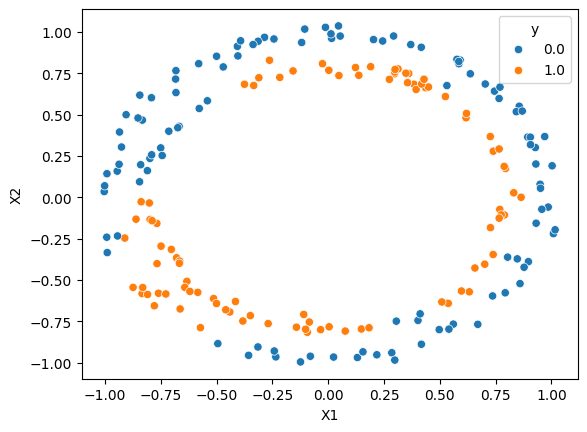

In [26]:
df_pred = pd.DataFrame(
    np.hstack((X_test.numpy(), y_test_labels.numpy().reshape(-1, 1))),
    columns=['X1', 'X2', 'y']
)
sns.scatterplot(data=df_pred, x='X1', y='X2', hue='y')

## Replicating Nonlinear Activation Functions

In [28]:
A = torch.arange(-10, 10).type(torch.float)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

In [33]:
def relu(x):
    return torch.maximum(torch.zeros_like(x), x)

In [38]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

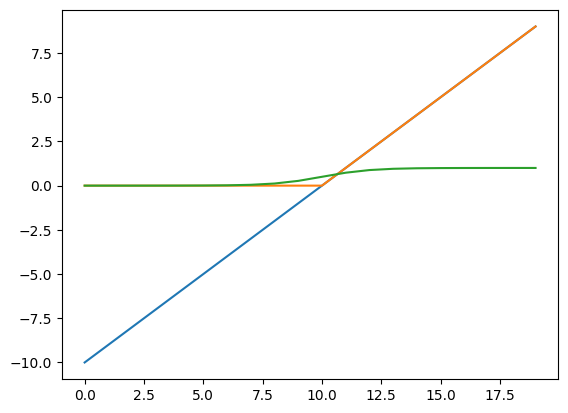

In [39]:
plt.plot(A)
plt.plot(relu(A))
plt.plot(sigmoid(A))
plt.show()

## Multiclass PyTorch Model